## Librerías

In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Trayectorias gravitacionales: Explorando el problema de los dos cuerpos con métodos computacionales


---
### Laura Sofía Sierra Sánchez
### Juan Sebastian Novoa Ortiz
*Métodos computacionales*

---

## 1. Introducción y Marco Teórico

Este proyecto aborda uno de los problemas fundamentales de la mecánica celeste: el **problema de los dos cuerpos**. El objetivo es simular y visualizar la trayectoria de dos cuerpos masivos (como una estrella y un planeta, o un planeta y su luna) que interactúan únicamente a través de su atracción gravitacional mutua. La base física de esta simulación es la **Ley de Gravitación Universal de Newton**.

### La Ecuación del Movimiento

La fuerza que el cuerpo 1 (masa $m_1$) ejerce sobre el cuerpo 2 (masa $m_2$) viene dada por:
$$ \vec{F}_{12} = -G \frac{m_1 m_2}{|\vec{r}_{12}|^3} \vec{r}_{12} $$
donde $\vec{r}_{12} = \vec{r}_2 - \vec{r}_1$ es el vector de posición de $m_2$ relativo a $m_1$. Por la segunda ley de Newton ($\vec{F} = m\vec{a}$), la aceleración de cada cuerpo es:

$$ \vec{a}_1 = \frac{d^2\vec{r}_1}{dt^2} = -G \frac{m_2}{|\vec{r}_{21}|^3} \vec{r}_{21} \quad \text{y} \quad \vec{a}_2 = \frac{d^2\vec{r}_2}{dt^2} = -G \frac{m_1}{|\vec{r}_{12}|^3} \vec{r}_{12} $$

Este es un sistema de **ecuaciones diferenciales ordinarias (EDOs)** de segundo orden. Para resolverlo numéricamente, lo convertimos en un sistema de EDOs de primer orden definiendo el **vector de estado** del sistema, que contiene las posiciones y velocidades de ambos cuerpos. Para un sistema 2D, este vector tiene 8 componentes:

$$ \vec{S} = [x_1, y_1, v_{x1}, v_{y1}, x_2, y_2, v_{x2}, v_{y2}] $$

La tarea del integrador numérico es encontrar $\vec{S}(t)$ a partir de un estado inicial $\vec{S}_0$.

### Leyes de Conservación para Validación

En un sistema aislado como este, ciertas cantidades físicas deben permanecer constantes a lo largo del tiempo. Verificar su conservación es la mejor manera de asegurar que nuestra simulación es físicamente correcta.

1.  **Energía Total ($E$):** La suma de la energía cinética ($K$) y la energía potencial gravitacional ($U$) debe ser constante.
    $$ E = K + U = \left( \frac{1}{2}m_1 v_1^2 + \frac{1}{2}m_2 v_2^2 \right) - G\frac{m_1 m_2}{r_{12}} = \text{constante} $$

2.  **Momento Angular Total ($\vec{L}$):** El momento angular total del sistema, calculado respecto al origen (que en nuestra simulación es el centro de masas), también debe conservarse. Para un movimiento en 2D, nos enfocamos en la componente $z$.
    $$ \vec{L} = \vec{L}_1 + \vec{L}_2 = (\vec{r}_1 \times m_1\vec{v}_1) + (\vec{r}_2 \times m_2\vec{v}_2) = \text{constante} $$
    $$ L_z = m_1(x_1 v_{y1} - y_1 v_{x1}) + m_2(x_2 v_{y2} - y_2 v_{x2}) = \text{constante} $$

## 2. Configuración del Simulador

* **Librerías:** Importamos las herramientas necesarias: `numpy` para el cálculo numérico y manejo de vectores, `matplotlib.pyplot` para la visualización de resultados, y `scipy.integrate.solve_ivp` que es el potente integrador de EDOs que usaremos.
* **Constantes Físicas:** Se definen las constantes universales como `G` (constante de gravitación), `M_SOL` (masa del Sol) y `UA` (Unidad Astronómica) en unidades del Sistema Internacional (SI). Esto asegura la consistencia en todos los cálculos.
* **Catálogos de Datos:** Se crean diccionarios con datos reales de planetas, lunas y estrellas, así como menús de distancias típicas. Este enfoque permite al usuario explorar una amplia variedad de escenarios astrofísicos realistas de manera interactiva.

In [2]:
# Constantes fisicas (SI)
G = 6.67430e-11       # m^3 kg^-1 s^-2
M_SOL = 1.98847e30    # kg
UA = 1.495978707e11   # m
R_SOL = 6.957e8       # m
R_TIERRA = 6.371e6    # m

# Catalogos de masas (solo opciones ofrecidas)
PLANETAS = {
    "Mercurio": 3.3011e23,
    "Venus":    4.8675e24,
    "Tierra":   5.97237e24,
    "Marte":    6.4171e23,
    "Jupiter":  1.8982e27,
    "Saturno":  5.6834e26,
    "Urano":    8.6810e25,
    "Neptuno":  1.02413e26,
}

LUNAS = {
    "Luna (Tierra)":       7.342e22,
    "Phobos (Marte)":      1.0659e16,
    "Deimos (Marte)":      1.4762e15,
    "Io (Jupiter)":        8.9319e22,
    "Europa (Jupiter)":    4.7998e22,
    "Ganimedes (Jupiter)": 1.4819e23,
    "Calisto (Jupiter)":   1.0759e23,
    "Titan (Saturno)":     1.3452e23,
    "Triton (Neptuno)":    2.14e22,
}

ESTRELLAS = {
    "Proxima Centauri (0.122 Msol)": 0.1221 * M_SOL,
    "Enana roja (0.2 Msol)":         0.2 * M_SOL,
    "Enana K (0.7 Msol)":            0.7 * M_SOL,
    "Sol (1.0 Msol)":                1.0 * M_SOL,
    "Alfa Cen A (1.10 Msol)":        1.10 * M_SOL,
    "Alfa Cen B (0.91 Msol)":        0.91 * M_SOL,
    "Tipo F (1.3 Msol)":             1.3 * M_SOL,
    "Tipo A (2.0 Msol)":             2.0 * M_SOL,
    "Sirius A (2.06 Msol)":          2.063 * M_SOL,
    "Tipo B (5.0 Msol)":             5.0 * M_SOL,
    "Tipo O (20 Msol)":              20.0 * M_SOL,
}

# Menus de distancias (m) (solo opciones ofrecidas)
DIST_BINARIA = {
    "5 R_sol": 5 * R_SOL,
    "10 R_sol": 10 * R_SOL,
    "0.02 UA": 0.02 * UA,
    "0.05 UA": 0.05 * UA,
    "0.1 UA": 0.1 * UA,
    "0.5 UA": 0.5 * UA,
    "1 UA": 1.0 * UA,
    "5 UA": 5.0 * UA,
    "10 UA": 10.0 * UA,
    "50 UA": 50.0 * UA,
}

DIST_PLANETA_LUNA = {
    "Tierra-Luna": 384400e3,
    "Marte-Phobos": 9376e3,
    "Marte-Deimos": 23463e3,
    "Jupiter-Io": 421700e3,
    "Jupiter-Europa": 671100e3,
    "Jupiter-Ganimedes": 1070400e3,
    "Jupiter-Calisto": 1882700e3,
    "Saturno-Titan": 1221870e3,
    "Neptuno-Triton": 354800e3,
    "5 R_tierra": 5 * R_TIERRA,
    "10 R_tierra": 10 * R_TIERRA,
    "20 R_tierra": 20 * R_TIERRA,
}

DIST_ESTRELLA_PLANETA = {
    "Jupiter caliente (0.05 UA)": 0.05 * UA,
    "0.1 UA": 0.1 * UA,
    "Orbita de Mercurio (0.387 UA)": 0.387 * UA,
    "Orbita de Venus (0.723 UA)": 0.723 * UA,
    "Orbita de la Tierra (1 UA)": 1.0 * UA,
    "Orbita de Marte (1.524 UA)": 1.524 * UA,
    "2 UA": 2.0 * UA,
    "Orbita de Jupiter (5.204 UA)": 5.204 * UA,
    "10 UA": 10.0 * UA,
    "30 UA": 30.0 * UA,
}


## 3. Funciones Clave de la Simulación

El corazón del simulador reside en un conjunto de funciones que modelan la física y preparan las condiciones para la integración numérica.

### `ecuaciones_dos_cuerpos(t, y, m1, m2)`
Esta es la función más importante. Recibe el tiempo `t`, el vector de estado `y` (que contiene las posiciones y velocidades de ambos cuerpos), y las masas `m1` y `m2`. Su único propósito es calcular la derivada del vector de estado en ese instante, $d\vec{S}/dt$. El integrador `solve_ivp` llamará a esta función repetidamente para avanzar la simulación en el tiempo. La función devuelve un vector con las velocidades y aceleraciones de ambos cuerpos, que son las derivadas de las posiciones y velocidades, respectivamente.

### `energia_total()` y `momento_angular_total()`
Estas funciones toman la matriz de estados resultante de la simulación y calculan la energía total y el momento angular total en cada paso de tiempo. Se utilizan *a posteriori* para la validación: si estas cantidades se mantienen constantes, la simulación es precisa.

### `condiciones_iniciales()`
Esta función establece el punto de partida de la simulación. Para simplificar, coloca el **Centro de Masas (COM)** del sistema en el origen (0,0) y alinea los dos cuerpos sobre el eje x. Luego, calcula las velocidades iniciales necesarias para una órbita **circular** o **elíptica** a una distancia dada (`r0`).
- **Órbita Circular ($e=0$):** La velocidad relativa es perpendicular al vector de posición y su magnitud es $v_{rel} = \sqrt{G(m_1+m_2)/r_0}$.
- **Órbita Elíptica ($0 < e < 1$):** La simulación inicia en el pericentro (punto de máxima aproximación), donde la velocidad también es perpendicular al vector de posición. Su magnitud se calcula con la ecuación vis-viva: $v_{rel} = \sqrt{G(m_1+m_2)(1+e)/r_0}$.

### Funciones de Interfaz de Usuario
Las funciones `elegir_trayectoria`, `seleccionar_indice`, `seleccionar_masa`, `seleccionar_distancia`, y `presets_condiciones_iniciales` gestionan los menús interactivos, permitiendo al usuario configurar la simulación de forma intuitiva sin modificar el código.

In [3]:
def ecuaciones_dos_cuerpos(t, y, m1, m2):
    """
    Calcula derivadas del estado para dos cuerpos con gravedad de Newton.
    y: [x1, y1, vx1, vy1, x2, y2, vx2, vy2]
    Retorna: [vx1, vy1, ax1, ay1, vx2, vy2, ax2, ay2]
    """
    x1, y1, vx1, vy1, x2, y2, vx2, vy2 = y
    rx = x2 - x1
    ry = y2 - y1
    r2 = rx*rx + ry*ry
    r = math.sqrt(r2)
    if r == 0.0:
        ax1 = ay1 = ax2 = ay2 = 0.0
    else:
        inv_r3 = 1.0 / (r2 * r)
        ax1 = G * m2 * rx * inv_r3
        ay1 = G * m2 * ry * inv_r3
        ax2 = -G * m1 * rx * inv_r3
        ay2 = -G * m1 * ry * inv_r3
    return [vx1, vy1, ax1, ay1, vx2, vy2, ax2, ay2]

def energia_total(matriz_estado, m1, m2):
    """
    Calcula energia total (cinetica + potencial) en el tiempo.
    Retorna array con energia total por instante.
    """
    x1, y1, vx1, vy1, x2, y2, vx2, vy2 = matriz_estado
    v1_2 = vx1*vx1 + vy1*vy1
    v2_2 = vx2*vx2 + vy2*vy2
    rx = x2 - x1
    ry = y2 - y1
    r = np.sqrt(rx*rx + ry*ry)
    K = 0.5*m1*v1_2 + 0.5*m2*v2_2
    U = -G*m1*m2 / r
    return K + U

def momento_angular_total(matriz_estado, m1, m2):
    """
    Calcula el momento angular total (componente z) en el tiempo.
    Retorna array Lz.
    """
    x1, y1, vx1, vy1, x2, y2, vx2, vy2 = matriz_estado
    L1 = m1 * (x1*vy1 - y1*vx1)
    L2 = m2 * (x2*vy2 - y2*vx2)
    return L1 + L2

def periodo_desde_semieje(a, m1, m2):
    """
    Calcula periodo orbital T desde semieje mayor a (ley de Kepler).
    """
    M = m1 + m2
    return 2.0 * math.pi * math.sqrt(a**3 / (G * M))

def malla_tiempo(T, n_periodos, puntos_por_periodo=1000, min_puntos=3000):
    """
    Genera un vector de tiempos uniforme para n_periodos.
    Retorna (tiempos, T_total).
    """
    T_total = n_periodos * T
    N = max(int(puntos_por_periodo * n_periodos), min_puntos)
    return np.linspace(0.0, T_total, N), T_total

def elegir_trayectoria():
    """
    Permite elegir circular o eliptica; si eliptica pide excentricidad.
    Retorna (tipo, e).
    """
    print("Tipo de trayectoria:")
    print("  1) Circular")
    print("  2) Eliptica (inicio en pericentro)")
    while True:
        c = input("Elija [1/2]: ").strip()
        if c == "1":
            return ("circular", 0.0)
        if c == "2":
            break
        print("Opcion invalida.")
    while True:
        try:
            e = float(input("Excentricidad e (0 < e < 1): ").strip())
            if 0.0 < e < 1.0:
                return ("eliptica", e)
        except ValueError:
            pass
        print("Valor invalido. Intente de nuevo.")

def condiciones_iniciales(m1, m2, r0, tipo_trayectoria, e=0.0):
    """
    Genera condiciones iniciales con COM en el origen sobre eje x.
    Circular: v = sqrt(GM/r0). Eliptica (pericentro): v = sqrt(GM*(1+e)/r0).
    Retorna (y0, tiempos, T, nP).
    """
    x1 = - (m2/(m1+m2)) * r0
    x2 = + (m1/(m1+m2)) * r0
    y1 = y2 = 0.0

    M = m1 + m2
    if tipo_trayectoria == "circular":
        v_rel = math.sqrt(G * M / r0)
        a = r0
        nP = 3.0
    else:
        v_rel = math.sqrt(G * M * (1.0 + e) / r0)
        a = r0 / (1.0 - e)
        nP = 5.0

    v1_mod = v_rel * (m2 / (m1 + m2))
    v2_mod = v_rel * (m1 / (m1 + m2))
    v1 = np.array([0.0, -v1_mod])
    v2 = np.array([0.0, +v2_mod])

    y0 = np.array([x1, y1, v1[0], v1[1], x2, y2, v2[0], v2[1]], dtype=float)
    T = periodo_desde_semieje(a, m1, m2)
    tiempos, _ = malla_tiempo(T, nP)
    return y0, tiempos, T, nP

def seleccionar_indice(nombres, mensaje):
    """
    Muestra una lista enumerada y solicita un indice valido.
    Retorna el indice seleccionado (0-based).
    """
    print(mensaje)
    for i, nombre in enumerate(nombres, 1):
        print(f"  {i}) {nombre}")
    while True:
        try:
            idx = int(input("Elija numero: ").strip())
            if 1 <= idx <= len(nombres):
                return idx - 1
        except ValueError:
            pass
        print("Seleccion invalida. Intente de nuevo.")

def seleccionar_masa(catalogo, mensaje):
    """
    Selecciona una masa desde un catalogo por numero (sin personalizados).
    Retorna (nombre, masa).
    """
    nombres = list(catalogo.keys())
    idx = seleccionar_indice(nombres, mensaje)
    nombre = nombres[idx]
    return nombre, catalogo[nombre]

def seleccionar_distancia(opciones, mensaje):
    """
    Selecciona una distancia desde un menu por numero (sin personalizados).
    Retorna (etiqueta, valor_metros).
    """
    etiquetas = list(opciones.keys())
    idx = seleccionar_indice(etiquetas, mensaje)
    etiqueta = etiquetas[idx]
    return etiqueta, opciones[etiqueta]

def presets_condiciones_iniciales():
    """
    Menu de sistemas: Binaria, Planeta-Luna, Estrella-Planeta.
    Permite elegir masas y distancias solo de las opciones ofrecidas.
    Retorna (m1, m2, y0, tiempos, etiqueta, info).
    """
    print("Sistemas predefinidos:")
    print("  A) Binaria (dos estrellas)")
    print("  B) Planeta-Luna")
    print("  C) Estrella-Planeta")
    elec = ""
    while elec not in ("A", "B", "C"):
        elec = input("Elija sistema [A/B/C]: ").strip().upper()

    tipo, e = elegir_trayectoria()

    if elec == "A":
        nombre_e1, m1 = seleccionar_masa(ESTRELLAS, "Seleccione estrella primaria:")
        nombre_e2, m2 = seleccionar_masa(ESTRELLAS, "Seleccione estrella secundaria:")
        etiqueta_r, r0 = seleccionar_distancia(DIST_BINARIA, "Seleccione separacion inicial r0:")
        y0, tiempos, T, nP = condiciones_iniciales(m1, m2, r0, tipo, e)
        etiqueta = f"Binaria: {nombre_e1} + {nombre_e2} ({tipo}{'' if tipo=='circular' else f', e={e:.3f}'}, r0={etiqueta_r})"
        info = {"r0": r0, "T": T, "periodos": nP}
        return m1, m2, y0, tiempos, etiqueta, info

    if elec == "B":
        nombre_p, m1 = seleccionar_masa(PLANETAS, "Seleccione planeta central:")
        nombre_l, m2 = seleccionar_masa(LUNAS, "Seleccione luna:")
        etiqueta_r, r0 = seleccionar_distancia(DIST_PLANETA_LUNA, "Seleccione separacion inicial r0:")
        y0, tiempos, T, nP = condiciones_iniciales(m1, m2, r0, tipo, e)
        etiqueta = f"Planeta-Luna: {nombre_p} + {nombre_l} ({tipo}{'' if tipo=='circular' else f', e={e:.3f}'}, r0={etiqueta_r})"
        info = {"r0": r0, "T": T, "periodos": nP}
        return m1, m2, y0, tiempos, etiqueta, info

    nombre_e, m1 = seleccionar_masa(ESTRELLAS, "Seleccione estrella central:")
    nombre_p, m2 = seleccionar_masa(PLANETAS, "Seleccione planeta:")
    etiqueta_r, r0 = seleccionar_distancia(DIST_ESTRELLA_PLANETA, "Seleccione separacion inicial r0:")
    y0, tiempos, T, nP = condiciones_iniciales(m1, m2, r0, tipo, e)
    etiqueta = f"Estrella-Planeta: {nombre_e} + {nombre_p} ({tipo}{'' if tipo=='circular' else f', e={e:.3f}'}, r0={etiqueta_r})"
    info = {"r0": r0, "T": T, "periodos": nP}
    return m1, m2, y0, tiempos, etiqueta, info

## 4. Ejecución y Visualización

La función `ejecutar_simulacion` es la que finalmente resuelve el problema y presenta los resultados.

### `scipy.integrate.solve_ivp`
Esta función de SciPy es un solucionador de problemas de valor inicial para EDOs. Le proporcionamos la función que define las derivadas (`ecuaciones_dos_cuerpos`), el intervalo de tiempo, el estado inicial, y los puntos en los que queremos la solución. 

Una modificación crucial para la precisión de las simulaciones orbitales es el uso de las tolerancias `rtol` (tolerancia relativa) y `atol` (tolerancia absoluta). Al establecer valores muy pequeños (ej. `1e-12`), le exigimos al integrador que sea extremadamente preciso en cada paso. Esto es fundamental para evitar que los errores numéricos se acumulen y causen que las órbitas se desvíen o que la energía no se conserve a largo plazo.

### Visualización de Resultados
Una vez que `solve_ivp` devuelve la solución (una matriz con el estado del sistema en cada instante de tiempo), se procede a graficar:

1.  **Trayectoria 2D:** Muestra las órbitas de ambos cuerpos alrededor del centro de masas. Permite verificar visualmente si las trayectorias son cerradas y estables (como se espera para órbitas elípticas o circulares).
2.  **Conservación de Energía:** Grafica el cambio fraccional de la energía total, $(E(t) - E_0) / E_0$. Para una simulación precisa, esta gráfica debe ser una línea muy cercana a cero, con pequeñas fluctuaciones numéricas.
3.  **Conservación de Momento Angular:** Similarmente, muestra el cambio fraccional del momento angular, $(L_z(t) - L_{z0}) / L_{z0}$. También debe permanecer muy cerca de cero.

Simulador interactivo 2D de dos cuerpos (solo opciones ofrecidas)
-----------------------------------------------------------------
Sistemas predefinidos:
  A) Binaria (dos estrellas)
  B) Planeta-Luna
  C) Estrella-Planeta
Tipo de trayectoria:
  1) Circular
  2) Eliptica (inicio en pericentro)
Opcion invalida.
Seleccione estrella primaria:
  1) Proxima Centauri (0.122 Msol)
  2) Enana roja (0.2 Msol)
  3) Enana K (0.7 Msol)
  4) Sol (1.0 Msol)
  5) Alfa Cen A (1.10 Msol)
  6) Alfa Cen B (0.91 Msol)
  7) Tipo F (1.3 Msol)
  8) Tipo A (2.0 Msol)
  9) Sirius A (2.06 Msol)
  10) Tipo B (5.0 Msol)
  11) Tipo O (20 Msol)
Seleccione estrella secundaria:
  1) Proxima Centauri (0.122 Msol)
  2) Enana roja (0.2 Msol)
  3) Enana K (0.7 Msol)
  4) Sol (1.0 Msol)
  5) Alfa Cen A (1.10 Msol)
  6) Alfa Cen B (0.91 Msol)
  7) Tipo F (1.3 Msol)
  8) Tipo A (2.0 Msol)
  9) Sirius A (2.06 Msol)
  10) Tipo B (5.0 Msol)
  11) Tipo O (20 Msol)
Seleccione separacion inicial r0:
  1) 5 R_sol
  2) 10 R_sol
  

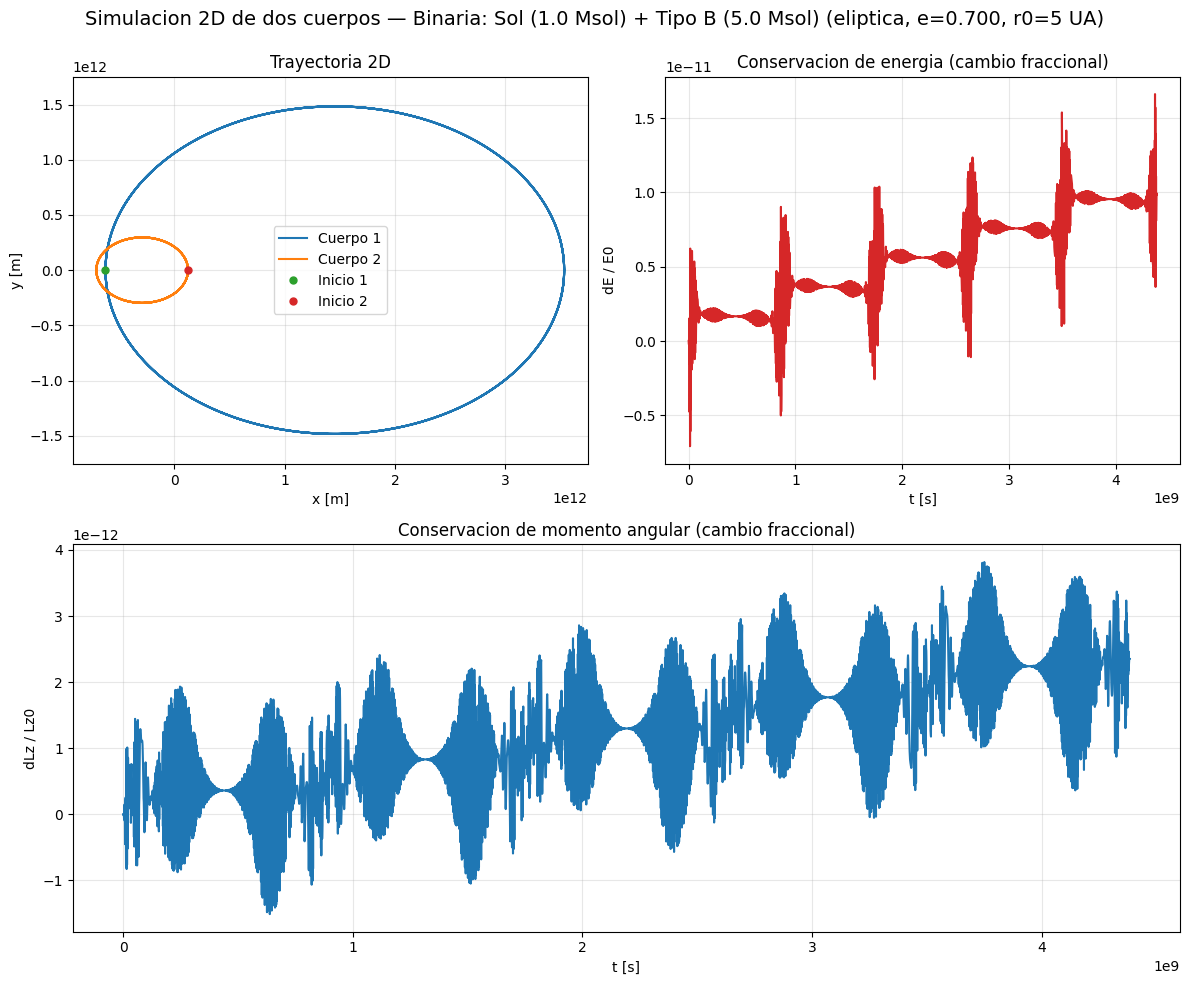

In [11]:
def ejecutar_simulacion(m1, m2, y0, tiempos, etiqueta):
    """
    Integra el sistema y genera 3 graficas:
    - Trayectoria 2D
    - Conservacion de energia (cambio fraccional)
    - Conservacion de momento angular (cambio fraccional)
    """
    print("Ejecutando simulacion...")
    # ======== INICIO DEL CAMBIO ========
    # Añadimos tolerancias muy pequeñas (rtol y atol) para aumentar la precisión.
    # Esto es crucial para la estabilidad a largo plazo en problemas orbitales.
    sol = solve_ivp(
        fun=lambda t, y: ecuaciones_dos_cuerpos(t, y, m1, m2),
        t_span=(tiempos[0], tiempos[-1]),
        y0=y0,
        t_eval=tiempos,
        method="RK45",
        rtol=1e-12,  # Tolerancia relativa
        atol=1e-12   # Tolerancia absoluta
    )
    # ======== FIN DEL CAMBIO ========

    if not sol.success:
        print("Fallo la integracion:", sol.message)
        sys.exit(1)

    matriz_estado = sol.y
    t = sol.t

    E = energia_total(matriz_estado, m1, m2)
    Lz = momento_angular_total(matriz_estado, m1, m2)
    E0 = E[0]; L0 = Lz[0]
    dE_rel = (E - E0) / max(abs(E0), 1e-30)
    dL_rel = (Lz - L0) / max(abs(L0), 1e-30)

    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(f"Simulacion 2D de dos cuerpos — {etiqueta}", fontsize=14)

    ax1 = plt.subplot(2, 2, 1)
    ax2 = plt.subplot(2, 2, 2)
    ax3 = plt.subplot(2, 1, 2)

    x1, y1, vx1, vy1, x2, y2, vx2, vy2 = matriz_estado

    ax1.plot(x1, y1, label="Cuerpo 1", lw=1.5)
    ax1.plot(x2, y2, label="Cuerpo 2", lw=1.5)
    ax1.plot([x1[0]], [y1[0]], "o", ms=5, label="Inicio 1")
    ax1.plot([x2[0]], [y2[0]], "o", ms=5, label="Inicio 2")
    ax1.set_aspect("equal", adjustable="datalim")
    ax1.set_xlabel("x [m]"); ax1.set_ylabel("y [m]")
    ax1.set_title("Trayectoria 2D")
    ax1.legend(loc="best"); ax1.grid(True, alpha=0.3)

    ax2.plot(t, dE_rel, color="tab:red")
    ax2.set_xlabel("t [s]"); ax2.set_ylabel("dE / E0")
    ax2.set_title("Conservacion de energia (cambio fraccional)")
    ax2.grid(True, alpha=0.3)

    ax3.plot(t, dL_rel, color="tab:blue")
    ax3.set_xlabel("t [s]"); ax3.set_ylabel("dLz / Lz0")
    ax3.set_title("Conservacion de momento angular (cambio fraccional)")
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ===================== Flujo interactivo (solo opciones ofrecidas) =====================

print("Simulador interactivo 2D de dos cuerpos (solo opciones ofrecidas)")
print("-----------------------------------------------------------------")

m1, m2, y0, tiempos, etiqueta, info = presets_condiciones_iniciales()

print("Resumen:")
print(f"  m1 = {m1:.6e} kg")
print(f"  m2 = {m2:.6e} kg")
print(f"  Separacion inicial r0 = {info['r0']:.6e} m")
print(f"  Periodo estimado T = {info['T']:.6e} s, simulando ~{info['periodos']} periodos")

ejecutar_simulacion(m1, m2, y0, tiempos, etiqueta)

## 5. Conclusión

Este notebook demuestra cómo los métodos computacionales, en particular la integración numérica de ecuaciones diferenciales, permiten resolver problemas complejos de la física que no tienen soluciones analíticas sencillas. A través de una interfaz interactiva, es posible simular y validar una amplia gama de sistemas astrofísicos, verificando la precisión del modelo mediante la conservación de la energía y el momento angular.